## Auction Performance Analysis

In [2]:
## Importing libraries - 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pymc3 as pm 
import arviz as az 
from theano import shared 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,FunctionTransformer,LabelEncoder
from sklearn.pipeline import FeatureUnion,Pipeline
from sklearn.metrics import mean_squared_error

/Users/shaswatrajput/dl/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['figure.figsize'] = (12,7)

In [4]:
## Reading dataset
df = pd.read_csv('data/auctions.csv')

In [5]:
## Checking first 5 entries in data 
df.head()

auction_id       RoR       STR       BPL  lots  product_types  \
0         100  1.026112  0.503097  8.324074   108       0.768519   
1         101  1.407666  1.000000  5.571429     7       1.000000   
2         102  0.000000  0.000000  0.000000     2       1.000000   
3         103  0.884021  1.000000  1.000000     3       0.333333   
4         104  0.972593  1.000000  4.533333    90       0.611111   

   avg_start_bid   avg_reserve    auction_mech state  
0            0.0  10568.250000       SealedBid    MD  
1            0.0   4805.617249  EnglishForward    TX  
2            0.0   3550.000000       SealedBid    MD  
3            0.0   7693.876790      FixedPrice    NE  
4            0.0   8661.111111  EnglishForward    NY

In [6]:
## Statistics of Data
df.describe()

auction_id          RoR          STR          BPL         lots  \
count  6220.000000  6220.000000  6220.000000  6220.000000  6220.000000   
mean   3209.500000     0.914951     0.611735     3.753701    38.519775   
std    1795.703669     0.447089     0.348659     2.898889    37.934576   
min     100.000000     0.000000     0.000000     0.000000     1.000000   
25%    1654.750000     0.904324     0.308321     1.000000     9.000000   
50%    3209.500000     0.999141     0.646369     3.213203    27.000000   
75%    4764.250000     1.023121     1.000000     5.769231    55.000000   
max    6319.000000    24.481984     1.000000    20.000000   516.000000   

       product_types  avg_start_bid   avg_reserve  
count    6220.000000    6220.000000  6.220000e+03  
mean        0.777361       0.147165  1.407759e+04  
std         0.207024       0.343083  1.631786e+05  
min         0.002841       0.000000  2.000000e+02  
25%         0.687500       0.000000  7.382251e+03  
50%         0.812500       0.000000  1.005908e+04  
75%         0.933333       0.000000  1.376380e+04  
max         1.000000       1.000000  1.280807e+07

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   auction_id     6220 non-null   int64  
 1   RoR            6220 non-null   float64
 2   STR            6220 non-null   float64
 3   BPL            6220 non-null   float64
 4   lots           6220 non-null   int64  
 5   product_types  6220 non-null   float64
 6   avg_start_bid  6220 non-null   float64
 7   avg_reserve    6220 non-null   float64
 8   auction_mech   6220 non-null   object 
 9   state          6220 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 486.1+ KB


### Initial Variable Selection for Model - 

Our first goal is to understand and predict RoR value and for this I have chosen the following features from the datatset - <br>
<li>lots - For controlling the available features. </li>
<li>avg_reserve - For controlling lot value - e.g. lower value lots may see more bidders willing to go above the reserve and vice-versa</li>
<li>avg_start_bid - For controlling the public price</li>
<li>BPL - we know from basic auction theory, that the more bidders there are, then the better expected prices will be</li>
<li>auction_mech - whether the lots were traded via English Forward (EF) or Sealed Bid (SB) auctions </li>
<li>state - to control for differences between local markets.</li>

## Exploratory Data Analysis

In [8]:
vars = ['lots', 'avg_reserve', 'avg_start_bid','BPL', 'auction_mech', 'state']

In [9]:
df[['RoR']+vars].head()

RoR  lots   avg_reserve  avg_start_bid       BPL    auction_mech state
0  1.026112   108  10568.250000            0.0  8.324074       SealedBid    MD
1  1.407666     7   4805.617249            0.0  5.571429  EnglishForward    TX
2  0.000000     2   3550.000000            0.0  0.000000       SealedBid    MD
3  0.884021     3   7693.876790            0.0  1.000000      FixedPrice    NE
4  0.972593    90   8661.111111            0.0  4.533333  EnglishForward    NY

### Removing Outliers - 

As we have seen above in the statistics of data that there are indeed outliers in our data that can hinder the our model's performance. We will systematcially remove the outliers in the data based on what we know about data like removing auction prices rows where value is in million of dollars and based on this removing the mean price observation of top percentile. We can also see. that there is ambiguity surrounding the high RoR values so we will filter out top percentile of RoR values. We will also filter out fixed price events from data because RoR for these auctions is fixed at 1 and also where nothing was sold in the auction. 

In [10]:
model_df = df.loc[(df['RoR']>0) & (df['RoR']<df['RoR'].quantile(0.99)) 
& (df['auction_mech']!='FixedPrice')& (df['avg_reserve']<df['avg_reserve'].quantile(0.99)),:]

In [11]:
model_df.head()

auction_id       RoR       STR       BPL  lots  product_types  \
0         100  1.026112  0.503097  8.324074   108       0.768519   
1         101  1.407666  1.000000  5.571429     7       1.000000   
4         104  0.972593  1.000000  4.533333    90       0.611111   
6         106  1.089178  0.478172  3.100000    87       0.482759   
8         108  1.234607  1.000000  4.250000    12       0.750000   

   avg_start_bid   avg_reserve    auction_mech state  
0            0.0  10568.250000       SealedBid    MD  
1            0.0   4805.617249  EnglishForward    TX  
4            0.0   8661.111111  EnglishForward    NY  
6            1.0   5081.609195  EnglishForward    WA  
8            0.0   4020.779816  EnglishForward    TX

In [12]:
# model_df.assign(state = df['state'].apply(lambda x: 'state_'+x),
# auction_mech = df['auction_mech'].apply(lambda x: 'auction_mech_'+x))

In [13]:
model_df = model_df[['RoR']+vars]
model_df.describe()

RoR         lots   avg_reserve  avg_start_bid          BPL
count  4175.000000  4175.000000   4175.000000    4175.000000  4175.000000
mean      0.989743    48.491018  11099.072681       0.205143     4.997294
std       0.140135    39.081027   4910.386793       0.390067     2.653911
min       0.052569     1.000000    400.000000       0.000000     0.000000
25%       0.921498    17.000000   7378.053377       0.000000     2.885714
50%       1.000367    40.000000  10218.566667       0.000000     4.873239
75%       1.041915    74.000000  13731.054182       0.000000     6.764655
max       1.617087   516.000000  30198.234375       1.000000    20.000000

In [14]:
model_df.head()

RoR  lots   avg_reserve  avg_start_bid       BPL    auction_mech state
0  1.026112   108  10568.250000            0.0  8.324074       SealedBid    MD
1  1.407666     7   4805.617249            0.0  5.571429  EnglishForward    TX
4  0.972593    90   8661.111111            0.0  4.533333  EnglishForward    NY
6  1.089178    87   5081.609195            1.0  3.100000  EnglishForward    WA
8  1.234607    12   4020.779816            0.0  4.250000  EnglishForward    TX

In [15]:
# Let's check our target variable distribution-
sns.distplot(model_df['RoR']);

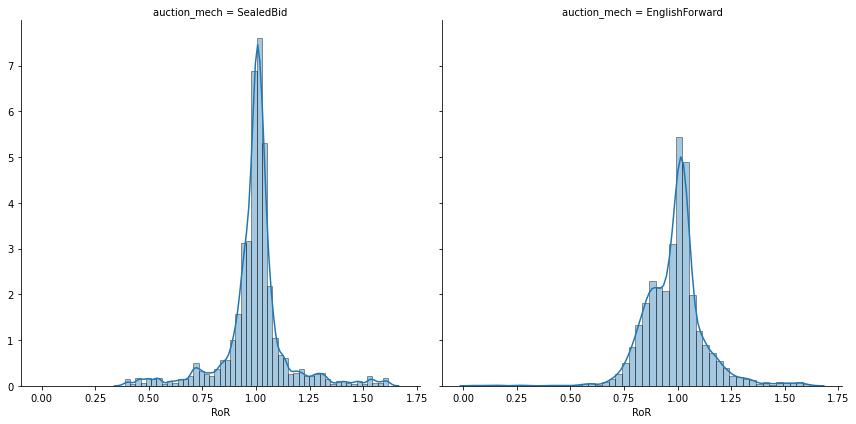

In [16]:
## Let's check RoR distribution based on auction mechanism used - 
sns.FacetGrid(model_df,col='auction_mech',height=6).map(sns.distplot,'RoR');

As we can see in the above plots that English Forward seems to have a bi-model distribution while the SealedBid seems to have a long tails and in this case student t-distribution might be a fucntion to consider here. 

Let's explore more about English Forward auction to see which feature might have caused this bi-modality. Since avergae start bid is directly relate to RoR since RoR is nothing but auction price divided by reserve price. Let's plt a scatter plot to see the relation between RoR and average start bid based on states. 

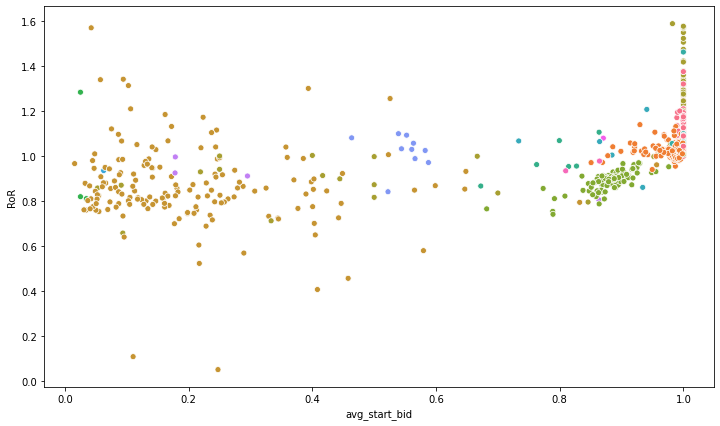

In [17]:
sns.scatterplot(x='avg_start_bid',y='RoR',hue='state',data=model_df[(model_df['auction_mech']=='EnglishForward') & (model_df['avg_start_bid']>0)],legend=False);

As we can see in above plot that there are some states where RoR is greater than average start bid price which cannot be true so we will filter out these auction events from our data before modeling. 

In [18]:
model_df = model_df[model_df['avg_start_bid']<1]

In [19]:
sns.distplot(model_df['RoR']);

We can see that even after filterimg out the data, bi-modality is still present. So we can say that this bi-modlaity is state based and that state feature can used to control the bi-modlaity in the RoR in dataset.  

<AxesSubplot:>

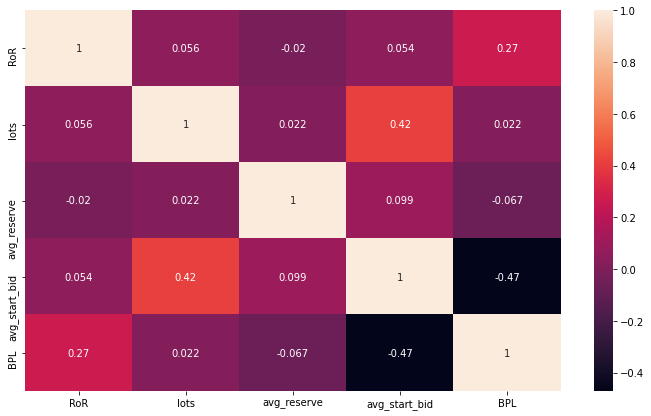

In [20]:
## Correlation between features - 
sns.heatmap(model_df.corr(),annot=True)

We can see from the above plot that the features in the dataset are not coorelated with each other which is agood sign. 

## Modeling 

Now before modeling I will center and scale the data and also I will use log transoform on target variable. 

In [21]:
def cat_col(df):
    df_cat = df.select_dtypes(include=['object'])
    return df_cat.values

def num_col(df):
    df_num = df.select_dtypes(exclude=['object'])
    return df_num.values

def make_new_vars(df):
    start_bid_map = (lambda x: 'start_bids_true' if x > 0 else 'start_bids_false')
    new_df = df.assign(start_bids=df['avg_start_bid'].apply(start_bid_map))
    return new_df

def cat_col_fact_names(df):
    def list_of_fact_names(col):
        fact_names = LabelEncoder().fit(col).classes_
        return fact_names.tolist()
    
    df_cat = df.select_dtypes(include=['object'])
    X = df_cat.values
    fact_name_cols = [(col_name, list_of_fact_names(col))
                      for col_name, col in zip(df_cat.columns, X.T)]
    
    return dict(fact_name_cols)

def cat_col_str2fact(X):
    fact_cols = [LabelEncoder().fit_transform(col) for col in X.T]
    fact_mat = np.vstack(fact_cols)
    return fact_mat.T

def make_new_vars(df):
    start_bid_map = (
        lambda x: 'start_bids_true' if x > 0 else 'start_bids_false')
    
    new_df = df.assign(start_bids=df['avg_start_bid'].apply(start_bid_map))
    return new_df

feat_pipe = Pipeline([
    ('make_new_vars', FunctionTransformer(make_new_vars, validate=False)),
    ('union', 
     FeatureUnion([
        ('num_vars', 
         Pipeline([
            ('get_num_vars',
             FunctionTransformer(num_col, validate=False)),
            ('scale_vars', StandardScaler())
         ])),
        ('cat_vars', 
         Pipeline([
            ('get_cat_vars',
             FunctionTransformer(cat_col, validate=False)),
            ('factorise',
             FunctionTransformer(cat_col_str2fact, validate=False))
         ]))
     ])
    )
])

In [22]:
## for data label - 
label_pipe = Pipeline([('log', FunctionTransformer(np.log, np.exp, validate=False))])

label_itfm = label_pipe.inverse_transform

In [23]:
# get variable names
num_var_names = (make_new_vars(model_df[vars]).select_dtypes(exclude=['object']).columns.tolist())

cat_var_names = (make_new_vars(model_df[vars]).select_dtypes(include=['object']).columns.tolist())

all_var_names = num_var_names + cat_var_names

cat_col_levels = cat_col_fact_names(make_new_vars(model_df[vars]))

In [24]:
## Get dependent and independent variable - 
y = label_pipe.fit_transform(model_df['RoR']).values.reshape(-1,)
X = feat_pipe.fit_transform(model_df[vars])

In [25]:
## Splitting data into train and test - 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [26]:
## setup for modeling - 
y = y_train
lots = X_train[:, 0]
avg_rsv = X_train[:, 1]
avg_start_bid = X_train[:, 2]
BPL = X_train[:, 3]
auction_mech = X_train[:, 4].astype('int32')
state = X_train[:, 5].astype('int32')
start_bid = X_train[:, 6].astype('int32')

n_state = len(set(X[:,5].tolist()))
n_mech = len(set(X[:,4].tolist())) ## 2

## Model 1 (Weakly Normalising Priors and Normal Likelihood)
For the first model I will be using a model with weak normalising priors and normal likelihood. For this I will choose mean to be 0 and sd to be 1. 

In [30]:
with pm.Model() as model_1:
    #Priors
    alpha_state = pm.Normal('alpha_c',mu=0,sd=1,shape=n_state)
    alpha_auc_mech = pm.Normal('alpha_auc_mech',mu=0,sd=1,shape=n_mech)
    alpha_bids = pm.Normal('alpha_bids',mu=0,sd=1,shape=2)
    beta_bpl = pm.Normal('beta_bpl',mu=0,sd=1,shape=1)
    beta_rsv = pm.Normal('beta_rsv',mu=0,sd=1,shape=1)
    beta_lots = pm.Normal('beta_lots',mu=0,sd=1,shape=1)

    sigma = pm.HalfCauchy('sigma',2)
    mu = (alpha_state[state]+ alpha_auc_mech[auction_mech]+ alpha_bids[start_bid]+ beta_bpl[0]*BPL + beta_rsv[0]*avg_rsv + beta_lots[0]*lots)

    # Likelihood
    pm.Normal('observed',mu=mu,sd=sigma,observed=y)

    #trace
    trace_1 = pm.sample(draws=5000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_lots, beta_rsv, beta_bpl, alpha_bids, alpha_auc_mech, alpha_c]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1525 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [31]:
az.summary(trace_1,hdi_prob=0.95)

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha_c[0]         0.044  0.200    -0.364      0.426      0.005    0.004   
alpha_c[1]         0.334  0.201    -0.062      0.725      0.005    0.004   
alpha_c[2]        -0.045  0.199    -0.440      0.343      0.005    0.004   
alpha_c[3]        -0.006  0.199    -0.410      0.379      0.005    0.004   
alpha_c[4]        -0.127  0.199    -0.531      0.255      0.005    0.004   
alpha_c[5]         0.155  0.199    -0.237      0.548      0.005    0.004   
alpha_c[6]         0.015  0.199    -0.388      0.395      0.005    0.004   
alpha_c[7]         0.100  0.201    -0.306      0.484      0.005    0.004   
alpha_c[8]        -0.062  0.200    -0.465      0.326      0.005    0.004   
alpha_c[9]         0.114  0.199    -0.280      0.507      0.005    0.004   
alpha_c[10]       -0.132  0.199    -0.523      0.264      0.005    0.004   
alpha_c[11]        0.005  0.199    -0.400      0.385      0.005    0.004   
alpha_c[12]        0.004  0.201    -0.405      0.389      0.005    0.004   
alpha_c[13]       -0.039  0.200    -0.442      0.346      0.005    0.004   
alpha_c[14]        0.045  0.200    -0.356      0.429      0.005    0.004   
alpha_c[15]       -0.093  0.206    -0.503      0.311      0.005    0.004   
alpha_c[16]        0.073  0.199    -0.345      0.443      0.005    0.004   
alpha_c[17]       -0.113  0.199    -0.507      0.277      0.005    0.004   
alpha_c[18]       -0.002  0.199    -0.396      0.388      0.005    0.004   
alpha_c[19]        0.156  0.220    -0.281      0.580      0.005    0.004   
alpha_c[20]       -0.121  0.199    -0.510      0.276      0.005    0.004   
alpha_c[21]       -0.123  0.198    -0.517      0.267      0.005    0.004   
alpha_c[22]       -0.074  0.199    -0.469      0.315      0.005    0.004   
alpha_c[23]        0.070  0.205    -0.328      0.476      0.005    0.004   
alpha_c[24]       -0.197  0.199    -0.597      0.187      0.005    0.004   
alpha_auc_mech[0]  0.018  0.511    -0.947      1.061      0.007    0.005   
alpha_auc_mech[1] -0.043  0.512    -1.090      0.919      0.007    0.005   
alpha_bids[0]     -0.003  0.514    -1.033      0.975      0.007    0.005   
alpha_bids[1]     -0.029  0.513    -1.041      0.966      0.007    0.005   
beta_bpl[0]        0.074  0.004     0.067      0.081      0.000    0.000   
beta_rsv[0]       -0.000  0.004    -0.007      0.007      0.000    0.000   
beta_lots[0]      -0.024  0.005    -0.033     -0.014      0.000    0.000   
sigma              0.141  0.002     0.138      0.145      0.000    0.000   

                   ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
alpha_c[0]           1359.0   1359.0    1357.0    2348.0    1.0  
alpha_c[1]           1363.0   1363.0    1362.0    2313.0    1.0  
alpha_c[2]           1344.0   1344.0    1342.0    2197.0    1.0  
alpha_c[3]           1350.0   1350.0    1348.0    2219.0    1.0  
alpha_c[4]           1344.0   1344.0    1343.0    2220.0    1.0  
alpha_c[5]           1347.0   1347.0    1345.0    2235.0    1.0  
alpha_c[6]           1338.0   1338.0    1337.0    2182.0    1.0  
alpha_c[7]           1354.0   1354.0    1353.0    2270.0    1.0  
alpha_c[8]           1372.0   1372.0    1370.0    2343.0    1.0  
alpha_c[9]           1343.0   1343.0    1342.0    2215.0    1.0  
alpha_c[10]          1351.0   1351.0    1350.0    2295.0    1.0  
alpha_c[11]          1343.0   1343.0    1341.0    2178.0    1.0  
alpha_c[12]          1373.0   1373.0    1372.0    2322.0    1.0  
alpha_c[13]          1349.0   1349.0    1347.0    2265.0    1.0  
alpha_c[14]          1357.0   1357.0    1357.0    2276.0    1.0  
alpha_c[15]          1437.0   1437.0    1435.0    2759.0    1.0  
alpha_c[16]          1347.0   1347.0    1345.0    2165.0    1.0  
alpha_c[17]          1346.0   1346.0    1344.0    2238.0    1.0  
alpha_c[18]          1339.0   1339.0    1337.0    2270.0    1.0  
alpha_c[19]          1684.0   1684.0    1683.0    3131.0    1.0  
alpha_c[20]          1351.0   1351.0    1349.0   

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  UserWarning,


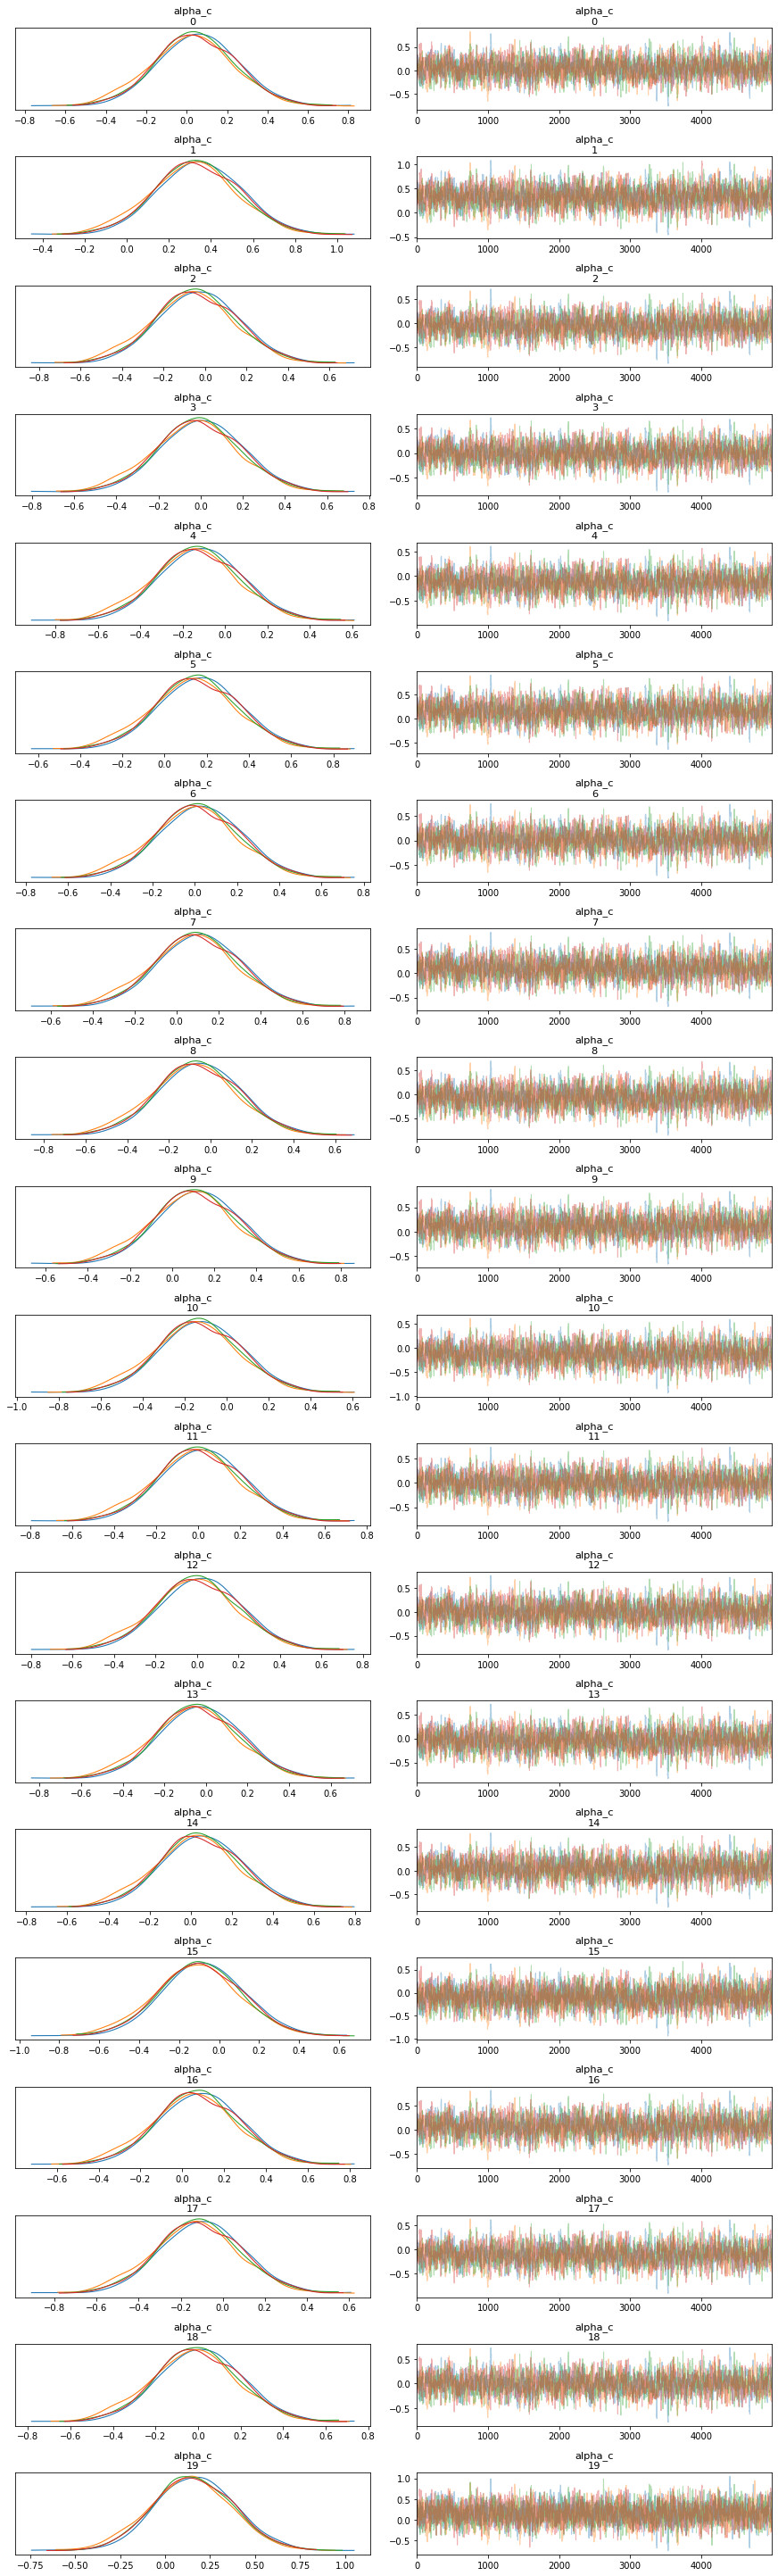

In [32]:
az.plot_trace(trace_1);

In [33]:
az.plot_forest(trace_1,r_hat=1,combined=True,ess=1,hdi_prob=0.95)

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

As we can see that in above plots that r_hat values are 1 and also our chains converged too which is a good sign. Our effective sample size for different features are large too which is good and shows that our experiment is acceptable. Based on these we can say our experiment has exploered the posterior distribution.

### Prediction on training set (In sample prediction):

In [34]:
# taking sample from posteriror
post_pred = pm.sample_posterior_predictive(trace=trace_1,samples=100,model=model_1)
pred_1 = post_pred['observed'].mean(axis=0)
error_1 = pred_1-y_train

/Users/shaswatrajput/dl/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


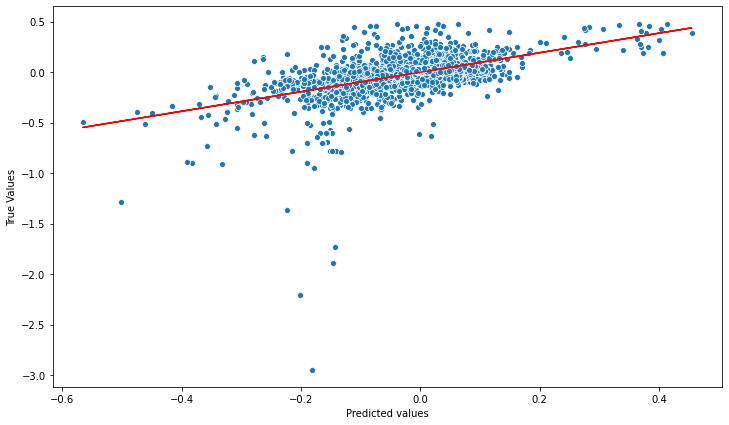

In [35]:
m, b = np.polyfit(pred_1, y_train, 1)
plt.plot(pred_1, m*pred_1 + b,color='red')
sns.scatterplot(pred_1,y_train)
plt.xlabel('Predicted values')
plt.ylabel('True Values');

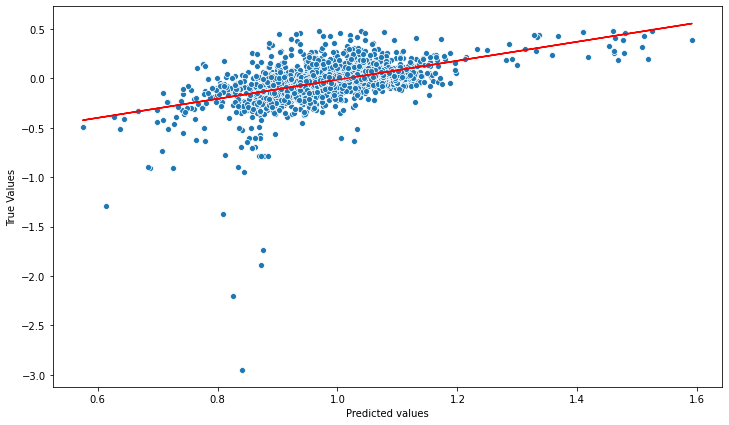

In [36]:
## PLotting with applying inverse log fucntion to target feature to convert it back to natural scale -- 
pred_1_invlog = label_itfm(post_pred['observed']).mean(axis=0)
m, b = np.polyfit(pred_1_invlog, y_train, 1)
plt.plot(pred_1_invlog, m*pred_1_invlog + b,color='red')
sns.scatterplot(pred_1_invlog,y_train)
plt.xlabel('Predicted values')
plt.ylabel('True Values');

In [285]:
print(f'RMSE is {np.sqrt(mean_squared_error(y_train,pred_1))}')

RMSE is 0.14147474818179887


As we can see that our model did ok as there are some very bad predictions too. We can check residuals too to look to make sure that the likelihood fucntion choice was ok and also to make sure that ther is no multi-modlaity. 

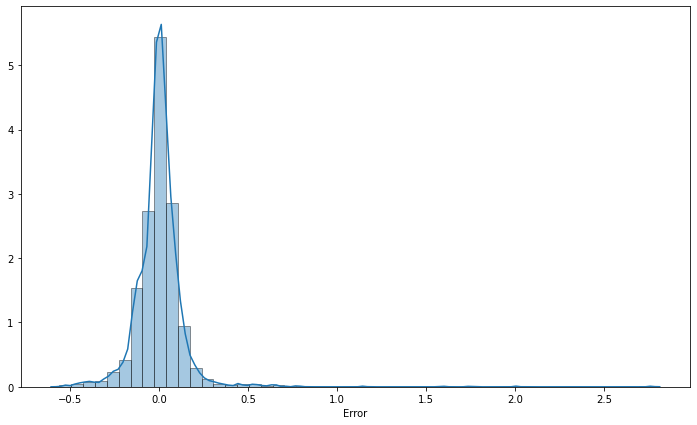

In [48]:
sns.distplot(error_1)
plt.xlabel('Error');

### Prediction on Test set (Out Sample Prediction) - 

In [163]:
post_pred_oss = pm.sample_posterior_predictive(trace=trace_1,samples=100,model=model_1)
pred_1_oss = label_itfm(post_pred_oss['observed']).mean(axis=0)

# m, b = np.polyfit(pred_1_oss, y_test, 1)
# plt.plot(pred_1_oss, m*pred_1_oss + b,color='red')
# sns.scatterplot(pred_1_oss,y_test)
# plt.xlabel('Predicted values')
# plt.ylabel('True Values');

## Model 2 (Weakly Normalising Priors and Normal Likelihood)
For the second model I will be using a model with weak normalising priors and normal likelihood. For this I will choose mean to be 0 and sd to be 0.2 because I want to to have low probability that a 1 standard deviation change in independent features to impact target (dependent) variable.

In [39]:
with pm.Model() as model_2:
    #Priors
    alpha_state = pm.Normal('alpha_c',mu=0,sd=0.2,shape=n_state)
    alpha_auc_mech = pm.Normal('alpha_auc_mech',mu=0,sd=0.2,shape=n_mech)
    alpha_bids = pm.Normal('alpha_bids',mu=0,sd=0.2,shape=2)
    beta_bpl = pm.Normal('beta_bpl',mu=0,sd=0.2,shape=1)
    beta_rsv = pm.Normal('beta_rsv',mu=0,sd=0.2,shape=1)
    beta_lots = pm.Normal('beta_lots',mu=0,sd=0.2,shape=1)

    sigma = pm.HalfCauchy('sigma',2)
    mu = (alpha_state[state]+ alpha_auc_mech[auction_mech]+ alpha_bids[start_bid]+ beta_bpl[0]*BPL + beta_rsv[0]*avg_rsv + beta_lots[0]*lots)

    # Likelihood
    pm.Normal('observed',mu=mu,sd=sigma,observed=y)

    #trace
    trace_2 = pm.sample(draws=2000,tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_lots, beta_rsv, beta_bpl, alpha_bids, alpha_auc_mech, alpha_c]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 147 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  UserWarning,


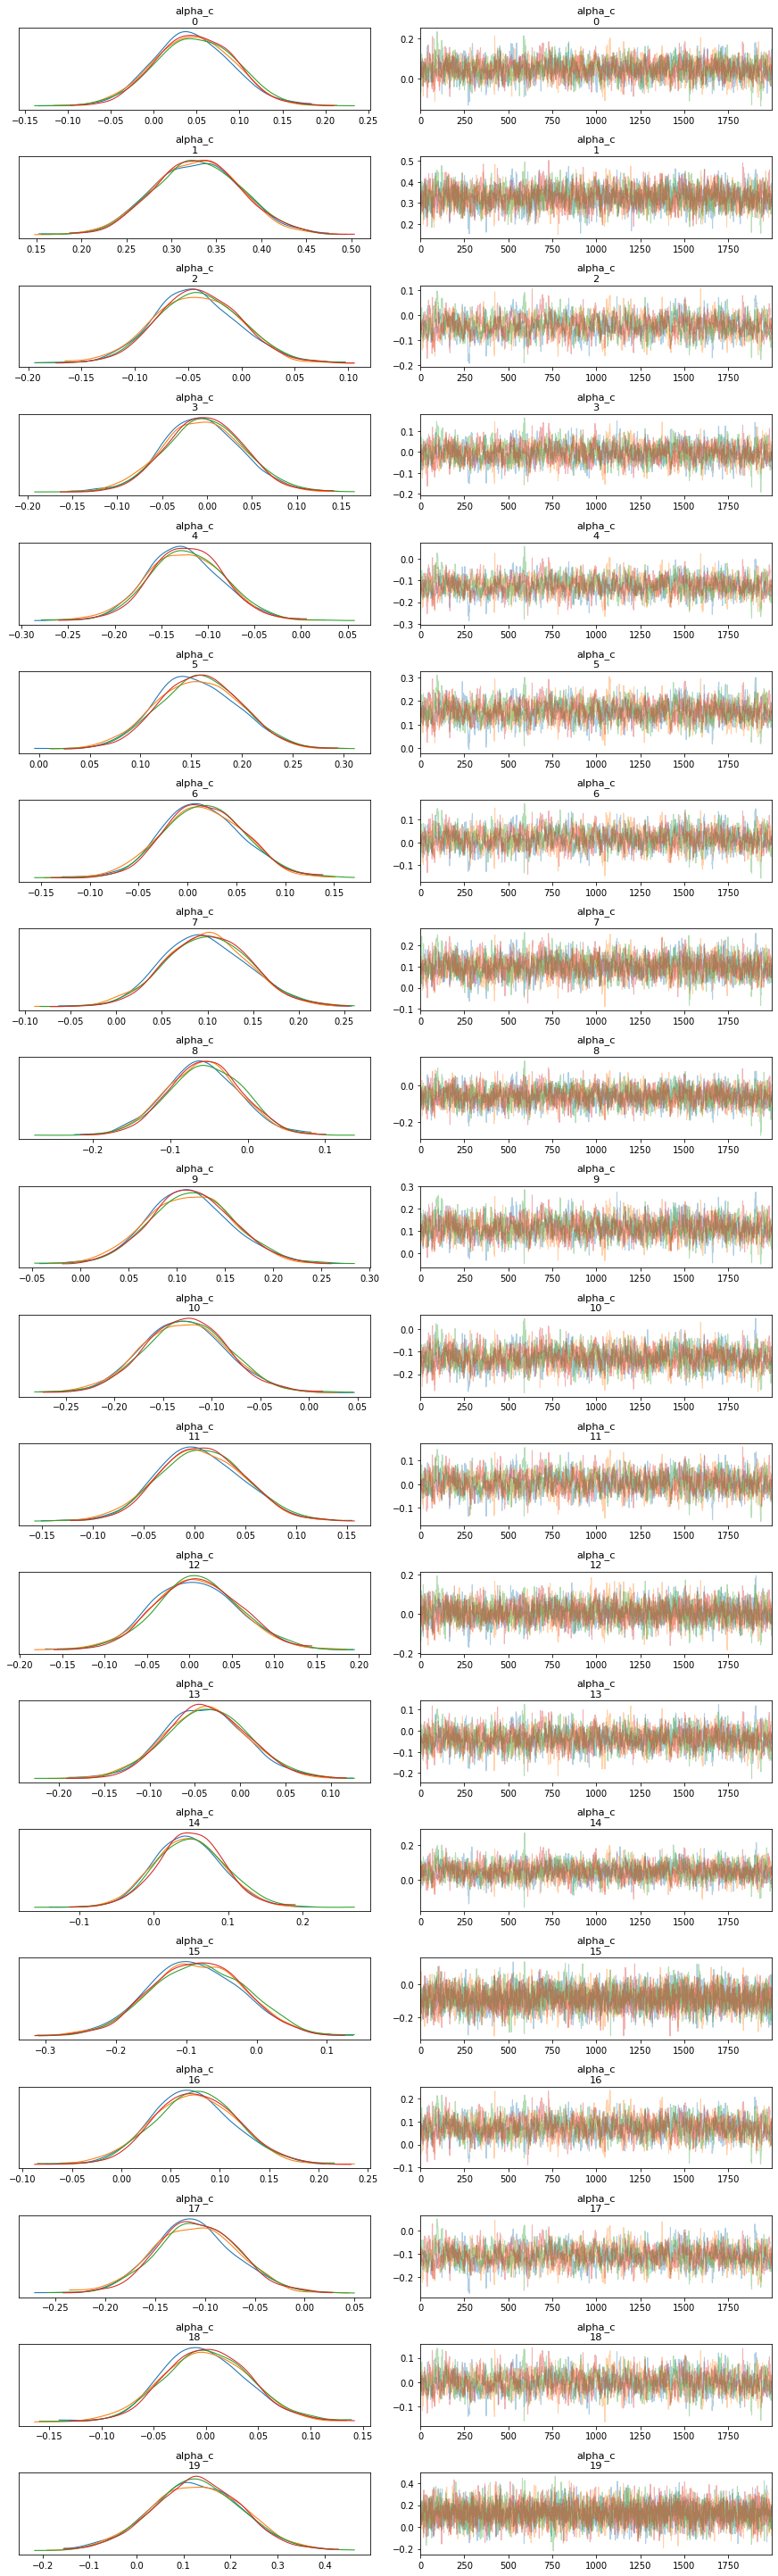

In [40]:
az.plot_trace(trace_2);

In [41]:
az.summary(trace_2,hdi_prob=0.95)

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha_c[0]         0.046  0.046    -0.044      0.134      0.001    0.001   
alpha_c[1]         0.328  0.048     0.233      0.419      0.001    0.001   
alpha_c[2]        -0.042  0.040    -0.118      0.036      0.001    0.001   
alpha_c[3]        -0.005  0.043    -0.089      0.080      0.001    0.001   
alpha_c[4]        -0.124  0.040    -0.202     -0.045      0.001    0.001   
alpha_c[5]         0.157  0.041     0.077      0.237      0.001    0.001   
alpha_c[6]         0.016  0.041    -0.063      0.097      0.001    0.001   
alpha_c[7]         0.099  0.046     0.005      0.186      0.001    0.001   
alpha_c[8]        -0.057  0.047    -0.153      0.032      0.001    0.001   
alpha_c[9]         0.114  0.043     0.028      0.198      0.001    0.001   
alpha_c[10]       -0.128  0.043    -0.210     -0.043      0.001    0.001   
alpha_c[11]        0.006  0.042    -0.074      0.088      0.001    0.001   
alpha_c[12]        0.008  0.050    -0.087      0.109      0.001    0.001   
alpha_c[13]       -0.038  0.045    -0.122      0.053      0.001    0.001   
alpha_c[14]        0.047  0.045    -0.037      0.140      0.001    0.001   
alpha_c[15]       -0.086  0.066    -0.208      0.046      0.001    0.001   
alpha_c[16]        0.074  0.042    -0.005      0.159      0.001    0.001   
alpha_c[17]       -0.110  0.041    -0.193     -0.033      0.001    0.001   
alpha_c[18]       -0.000  0.041    -0.076      0.086      0.001    0.001   
alpha_c[19]        0.127  0.095    -0.075      0.301      0.002    0.001   
alpha_c[20]       -0.117  0.043    -0.198     -0.031      0.001    0.001   
alpha_c[21]       -0.120  0.040    -0.198     -0.043      0.001    0.001   
alpha_c[22]       -0.071  0.040    -0.151      0.007      0.001    0.001   
alpha_c[23]        0.068  0.063    -0.056      0.191      0.001    0.001   
alpha_c[24]       -0.195  0.044    -0.276     -0.103      0.001    0.001   
alpha_auc_mech[0]  0.013  0.101    -0.180      0.215      0.002    0.001   
alpha_auc_mech[1] -0.045  0.101    -0.245      0.151      0.002    0.001   
alpha_bids[0]     -0.002  0.102    -0.203      0.190      0.002    0.001   
alpha_bids[1]     -0.027  0.102    -0.221      0.170      0.002    0.001   
beta_bpl[0]        0.074  0.004     0.067      0.081      0.000    0.000   
beta_rsv[0]       -0.000  0.004    -0.008      0.007      0.000    0.000   
beta_lots[0]      -0.024  0.005    -0.033     -0.014      0.000    0.000   
sigma              0.141  0.002     0.138      0.145      0.000    0.000   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
alpha_c[0]           1433.0  1356.0    1435.0    2285.0    1.0  
alpha_c[1]           1591.0  1579.0    1594.0    2394.0    1.0  
alpha_c[2]           1100.0  1100.0    1103.0    1459.0    1.0  
alpha_c[3]           1291.0  1291.0    1295.0    1749.0    1.0  
alpha_c[4]           1123.0  1123.0    1127.0    1499.0    1.0  
alpha_c[5]           1155.0  1106.0    1158.0    1533.0    1.0  
alpha_c[6]           1186.0  1186.0    1189.0    1721.0    1.0  
alpha_c[7]           1438.0  1410.0    1441.0    2383.0    1.0  
alpha_c[8]           1489.0  1489.0    1489.0    2547.0    1.0  
alpha_c[9]           1336.0  1281.0    1339.0    1949.0    1.0  
alpha_c[10]          1301.0  1301.0    1305.0    2276.0    1.0  
alpha_c[11]          1197.0  1197.0    1201.0    1751.0    1.0  
alpha_c[12]          1795.0  1795.0    1799.0    3291.0    1.0  
alpha_c[13]          1381.0  1381.0    1383.0    2001.0    1.0  
alpha_c[14]          1370.0  1293.0    1374.0    1919.0    1.0  
alpha_c[15]          2527.0  2527.0    2536.0    3983.0    1.0  
alpha_c[16]          1216.0  1146.0    1218.0    1648.0    1.0  
alpha_c[17]          1155.0  1155.0    1158.0    1689.0    1.0  
alpha_c[18]          1182.0  1182.0    1188.0    1805.0    1.0  
alpha_c[19]          3845.0  3845.0    3849.0    4360.0    1.0  
alpha_c[20]          1307.0  1307.0    1310.0    2152.0    1.0  
alpha

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

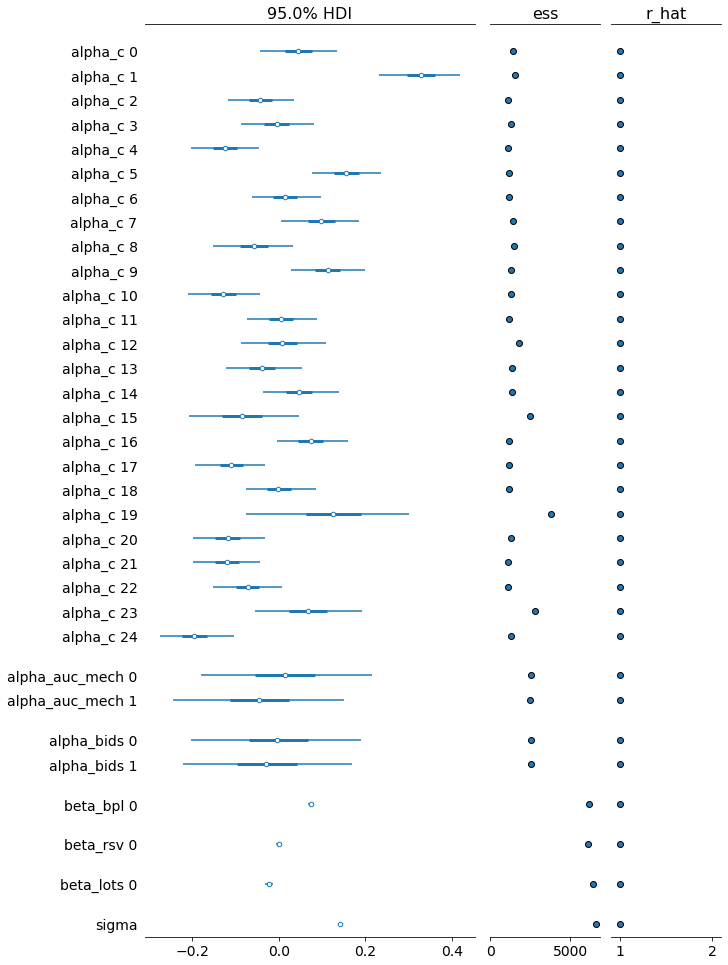

In [42]:
az.plot_forest(trace_2,r_hat=1,combined=True,ess=1,hdi_prob=0.95)

We can see that in the above forest plot that values distribution is not as spreaded like in model 1. We can also see that r_hat value is 1 and effective sample size is enough which supports that our model is effective. 

### Prediction on training set (In sample prediction):

In [259]:
# taking sample from posteriror
post_pred_2 = pm.sample_posterior_predictive(trace=trace_2,samples=1000,model=model_2)
pred_2 = post_pred_2['observed'].mean(axis=0)
error_2 = pred_2-y_train

/Users/shaswatrajput/dl/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


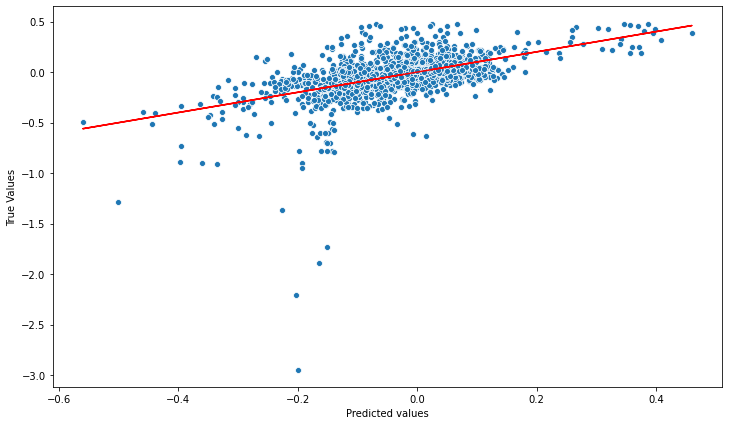

In [260]:
m, b = np.polyfit(pred_2, y_train, 1)
plt.plot(pred_2, m*pred_2 + b,color='red')
sns.scatterplot(pred_2,y_train)
plt.xlabel('Predicted values')
plt.ylabel('True Values');

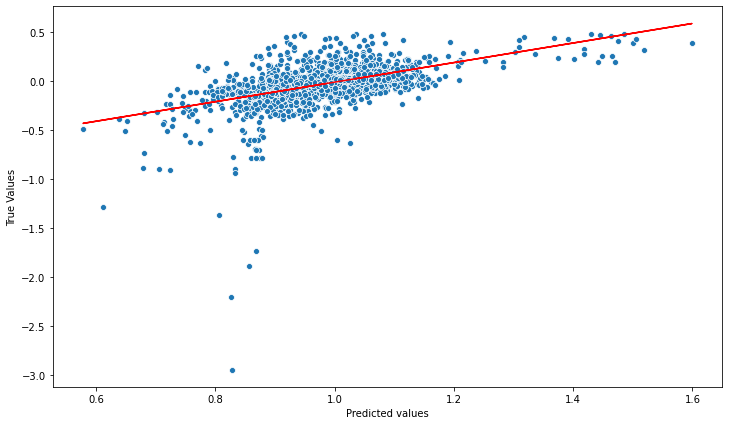

In [261]:
## PLotting with applying inverse log fucntion to target feature to convert it back to natural scale -- 
pred_2_invlog = label_itfm(post_pred_2['observed']).mean(axis=0)
m, b = np.polyfit(pred_2_invlog, y_train, 1)
plt.plot(pred_2_invlog, m*pred_2_invlog + b,color='red')
sns.scatterplot(pred_2_invlog,y_train)
plt.xlabel('Predicted values')
plt.ylabel('True Values');

In [284]:
print(f'RMSE is {np.sqrt(mean_squared_error(y_train,pred_2))}')

RMSE is 0.1406293798174968


As we can see that our model did ok as there are some very bad predictions too. We can check residuals too to look to make sure that the likelihood fucntion choice was ok and also to make sure that ther is no multi-modlaity. RMSE of model_2 is alsmost same as model_1.

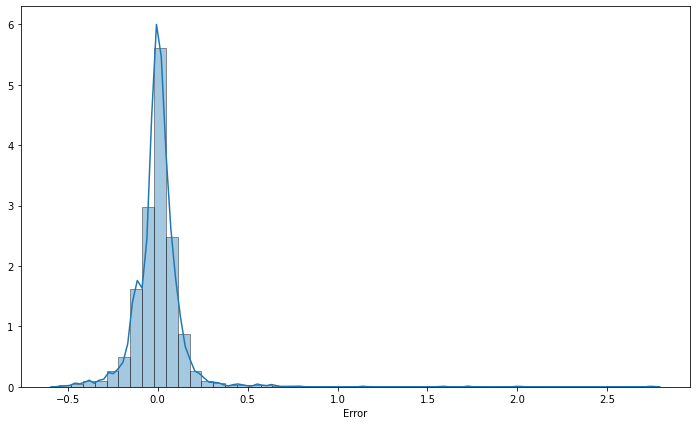

In [265]:
sns.distplot(error_2)
plt.xlabel('Error');

## Model 3 (Weakly Normalising Priors with student t-distribution)
For the thirrd model I will be using a model with weak normalising priors like model 2 and will use student t-distribution for robustness. For this I will choose mean to be 0 and sd to be 0.2 because I want to to have low probability that a 1 standard deviation change in independent features to impact target (dependent) variable.

In [69]:
with pm.Model() as model_3:
    #Priors
    alpha_state = pm.Normal('alpha_c',mu=0,sd=0.2,shape=n_state)
    alpha_auc_mech = pm.Normal('alpha_auc_mech',mu=0,sd=0.2,shape=n_mech)
    alpha_bids = pm.Normal('alpha_bids',mu=0,sd=0.2,shape=2)
    beta_bpl = pm.Normal('beta_bpl',mu=0,sd=0.2,shape=1)
    beta_rsv = pm.Normal('beta_rsv',mu=0,sd=0.2,shape=1)
    beta_lots = pm.Normal('beta_lots',mu=0,sd=0.2,shape=1)
    
    tau = pm.Uniform('tau', lower=0,upper=1)
    sigma = pm.HalfCauchy('sigma',2)
    mu = (alpha_state[state]+ alpha_auc_mech[auction_mech]+ alpha_bids[start_bid]+ beta_bpl[0]*BPL + beta_rsv[0]*avg_rsv + beta_lots[0]*lots)

    # Likelihood
    pm.StudentT('observed',mu=mu,sd=sigma,nu=1/tau,observed=y)

    #trace
    trace_3 = pm.sample(draws=2000,tune=500)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, beta_lots, beta_rsv, beta_bpl, alpha_bids, alpha_auc_mech, alpha_c]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 493 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (34), generating only 20 plots
  UserWarning,


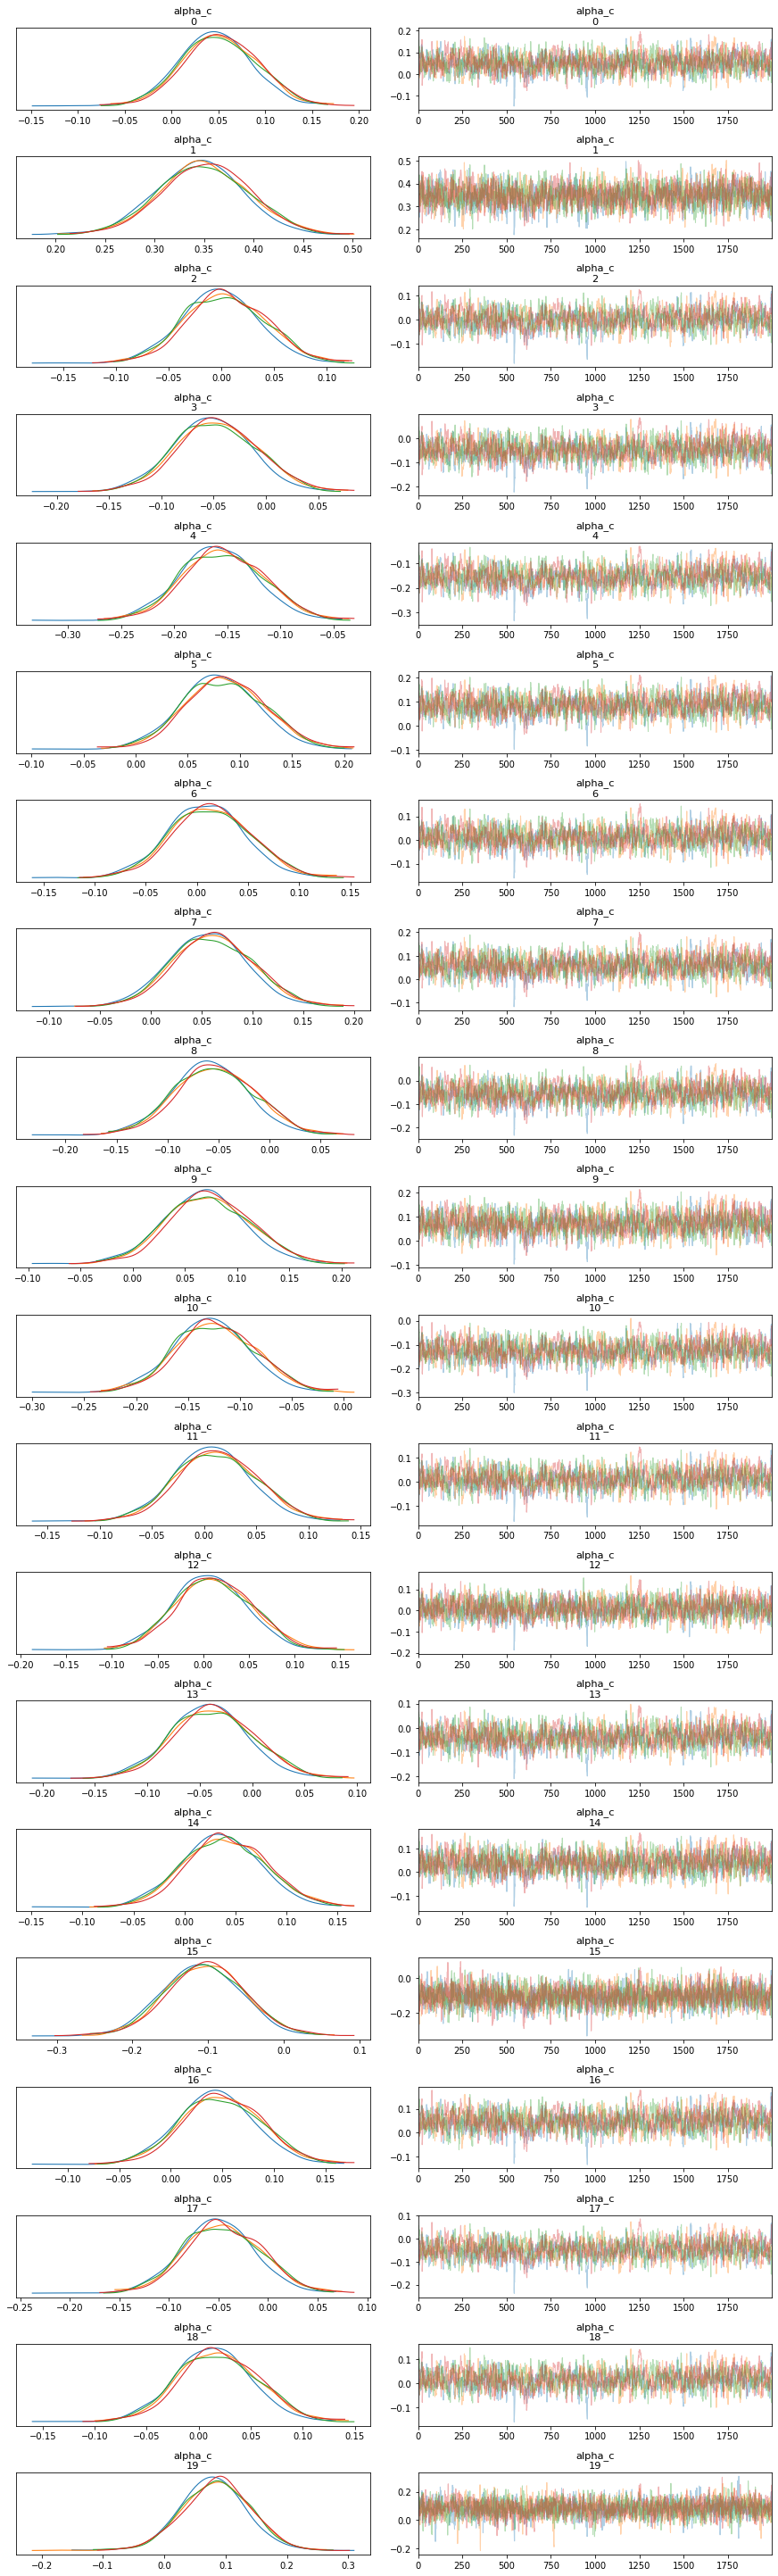

In [70]:
az.plot_trace(trace_3);

In [71]:
az.summary(trace_2,hdi_prob=0.95)

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha_c[0]         0.046  0.046    -0.044      0.134      0.001    0.001   
alpha_c[1]         0.328  0.048     0.233      0.419      0.001    0.001   
alpha_c[2]        -0.042  0.040    -0.118      0.036      0.001    0.001   
alpha_c[3]        -0.005  0.043    -0.089      0.080      0.001    0.001   
alpha_c[4]        -0.124  0.040    -0.202     -0.045      0.001    0.001   
alpha_c[5]         0.157  0.041     0.077      0.237      0.001    0.001   
alpha_c[6]         0.016  0.041    -0.063      0.097      0.001    0.001   
alpha_c[7]         0.099  0.046     0.005      0.186      0.001    0.001   
alpha_c[8]        -0.057  0.047    -0.153      0.032      0.001    0.001   
alpha_c[9]         0.114  0.043     0.028      0.198      0.001    0.001   
alpha_c[10]       -0.128  0.043    -0.210     -0.043      0.001    0.001   
alpha_c[11]        0.006  0.042    -0.074      0.088      0.001    0.001   
alpha_c[12]        0.008  0.050    -0.087      0.109      0.001    0.001   
alpha_c[13]       -0.038  0.045    -0.122      0.053      0.001    0.001   
alpha_c[14]        0.047  0.045    -0.037      0.140      0.001    0.001   
alpha_c[15]       -0.086  0.066    -0.208      0.046      0.001    0.001   
alpha_c[16]        0.074  0.042    -0.005      0.159      0.001    0.001   
alpha_c[17]       -0.110  0.041    -0.193     -0.033      0.001    0.001   
alpha_c[18]       -0.000  0.041    -0.076      0.086      0.001    0.001   
alpha_c[19]        0.127  0.095    -0.075      0.301      0.002    0.001   
alpha_c[20]       -0.117  0.043    -0.198     -0.031      0.001    0.001   
alpha_c[21]       -0.120  0.040    -0.198     -0.043      0.001    0.001   
alpha_c[22]       -0.071  0.040    -0.151      0.007      0.001    0.001   
alpha_c[23]        0.068  0.063    -0.056      0.191      0.001    0.001   
alpha_c[24]       -0.195  0.044    -0.276     -0.103      0.001    0.001   
alpha_auc_mech[0]  0.013  0.101    -0.180      0.215      0.002    0.001   
alpha_auc_mech[1] -0.045  0.101    -0.245      0.151      0.002    0.001   
alpha_bids[0]     -0.002  0.102    -0.203      0.190      0.002    0.001   
alpha_bids[1]     -0.027  0.102    -0.221      0.170      0.002    0.001   
beta_bpl[0]        0.074  0.004     0.067      0.081      0.000    0.000   
beta_rsv[0]       -0.000  0.004    -0.008      0.007      0.000    0.000   
beta_lots[0]      -0.024  0.005    -0.033     -0.014      0.000    0.000   
sigma              0.141  0.002     0.138      0.145      0.000    0.000   

                   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
alpha_c[0]           1433.0  1356.0    1435.0    2285.0    1.0  
alpha_c[1]           1591.0  1579.0    1594.0    2394.0    1.0  
alpha_c[2]           1100.0  1100.0    1103.0    1459.0    1.0  
alpha_c[3]           1291.0  1291.0    1295.0    1749.0    1.0  
alpha_c[4]           1123.0  1123.0    1127.0    1499.0    1.0  
alpha_c[5]           1155.0  1106.0    1158.0    1533.0    1.0  
alpha_c[6]           1186.0  1186.0    1189.0    1721.0    1.0  
alpha_c[7]           1438.0  1410.0    1441.0    2383.0    1.0  
alpha_c[8]           1489.0  1489.0    1489.0    2547.0    1.0  
alpha_c[9]           1336.0  1281.0    1339.0    1949.0    1.0  
alpha_c[10]          1301.0  1301.0    1305.0    2276.0    1.0  
alpha_c[11]          1197.0  1197.0    1201.0    1751.0    1.0  
alpha_c[12]          1795.0  1795.0    1799.0    3291.0    1.0  
alpha_c[13]          1381.0  1381.0    1383.0    2001.0    1.0  
alpha_c[14]          1370.0  1293.0    1374.0    1919.0    1.0  
alpha_c[15]          2527.0  2527.0    2536.0    3983.0    1.0  
alpha_c[16]          1216.0  1146.0    1218.0    1648.0    1.0  
alpha_c[17]          1155.0  1155.0    1158.0    1689.0    1.0  
alpha_c[18]          1182.0  1182.0    1188.0    1805.0    1.0  
alpha_c[19]          3845.0  3845.0    3849.0    4360.0    1.0  
alpha_c[20]          1307.0  1307.0    1310.0    2152.0    1.0  
alpha

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

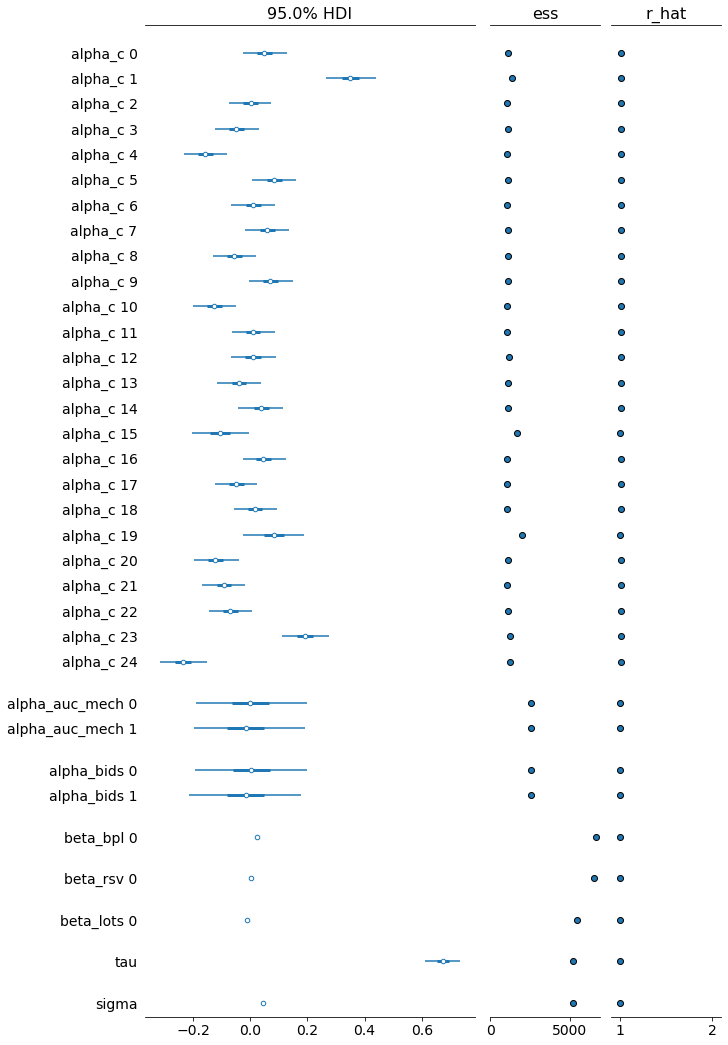

In [72]:
az.plot_forest(trace_3,r_hat=1,combined=True,ess=1,hdi_prob=0.95)

We can see that r_hat value are 1 and effective sample size is enough which supports that our model is effective. 

### Prediction on training set (In sample prediction):

In [299]:
# taking sample from posteriror
post_pred_3 = pm.sample_posterior_predictive(trace=trace_3,samples=500,model=model_3)
pred_3 = post_pred_3['observed'].mean(axis=0)
error_3 = pred_3-y_train

In [290]:
m, b = np.polyfit(pred_3, y_train, 1)
plt.plot(pred_3, m*pred_3 + b,color='red')
sns.scatterplot(pred_3,y_train)
plt.xlabel('Predicted values')
plt.ylabel('True Values');

In [291]:
sns.distplot(error_3)
plt.xlabel('Error');

In [293]:
print(f'RMSE is {np.sqrt(mean_squared_error(y_train,pred_3))}')

RMSE is 0.15079757997576484


## Model 4 (Hierarchical Model)

In [85]:
with pm.Model() as model_4:
    # Hyper-Priors -- 
    mu_state = pm.Normal('mu_state',mu=0,sd=0.2)
    sig_state = pm.HalfNormal('sig_state',sd=0.2)
    
    mu_auc_mech = pm.Normal('mu_auc_mech',mu=0,sd=0.2)
    sig_auc_mech = pm.HalfNormal('sig_auc_mech',sd=0.2)
    
    mu_bids = pm.Normal('mu_bids',mu=0,sd=0.2)
    sig_bids = pm.HalfNormal('sig_bids',sd=0.2)
    
    mu_bpl = pm.Normal('mu_bpl',mu=0,sd=0.2)
    sig_bpl = pm.HalfNormal('sig_bpl',sd=0.2)
    
    mu_rsv = pm.Normal('mu_rsv',mu=0,sd=0.2)
    sig_rsv = pm.HalfNormal('sig_rsv',sd=0.2)
    
    mu_lots = pm.Normal('mu_lots',mu=0,sd=0.2)
    sig_lots = pm.HalfNormal('sig_lots',sd=0.2)
    
    
    
    #Priors
    alpha_state = pm.Normal('alpha_c',mu=mu_state,sd=sig_state,shape=n_state)
    alpha_auc_mech = pm.Normal('alpha_auc_mech',mu=mu_auc_mech,sd=sig_auc_mech,shape=n_mech)
    alpha_bids = pm.Normal('alpha_bids',mu=mu_bids,sd=sig_bids,shape=2)
    beta_bpl = pm.Normal('beta_bpl',mu=mu_bpl,sd=sig_bpl,shape=1)
    beta_rsv = pm.Normal('beta_rsv',mu=mu_rsv,sd=sig_rsv,shape=1)
    beta_lots = pm.Normal('beta_lots',mu=mu_lots,sd=sig_lots,shape=1)
    

    sigma = pm.HalfCauchy('sigma',2)
    mu = (alpha_state[state]+ alpha_auc_mech[auction_mech]+ alpha_bids[start_bid]+ beta_bpl[0]*BPL + beta_rsv[0]*avg_rsv + beta_lots[0]*lots)

    # Likelihood
    pm.Normal('observed',mu=mu,sd=sigma,observed=y)

    #trace
    trace_4 = pm.sample(draws=2000,tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_lots, beta_rsv, beta_bpl, alpha_bids, alpha_auc_mech, alpha_c, sig_lots, mu_lots, sig_rsv, mu_rsv, sig_bpl, mu_bpl, sig_bids, mu_bids, sig_auc_mech, mu_auc_mech, sig_state, mu_state]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 443 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

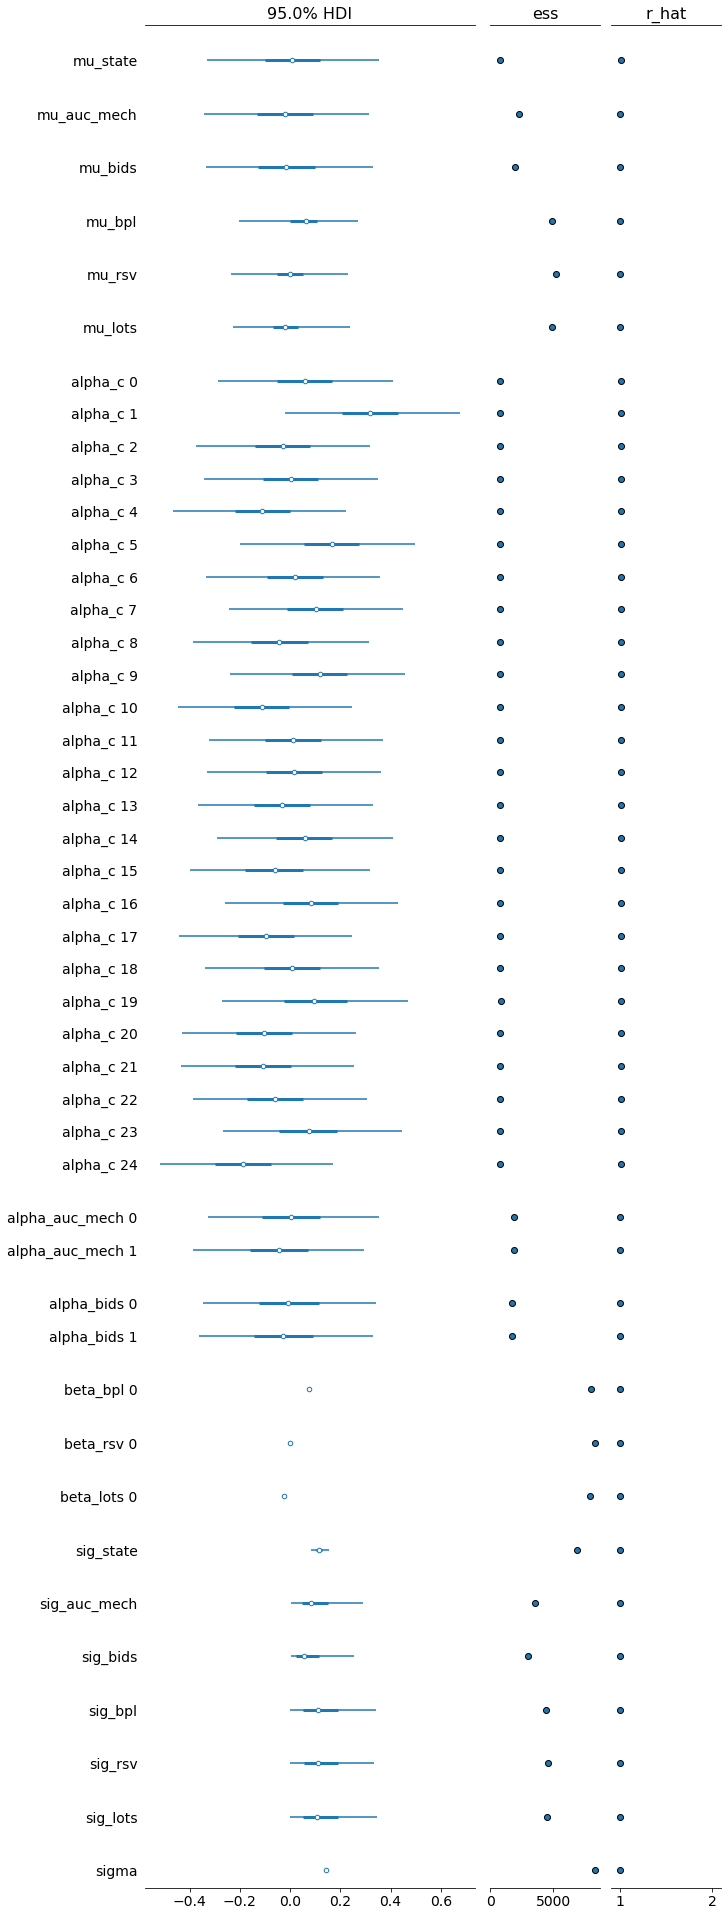

In [86]:
az.plot_forest(trace_4,r_hat=1,combined=True,ess=1,hdi_prob=0.95)

### Prediction on training set (In sample prediction):

In [266]:
post_pred_4 = pm.sample_posterior_predictive(trace=trace_4,samples=1000,model=model_4)
pred_4 = post_pred_4['observed'].mean(axis=0)
error_4 = pred_4-y_train

/Users/shaswatrajput/dl/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


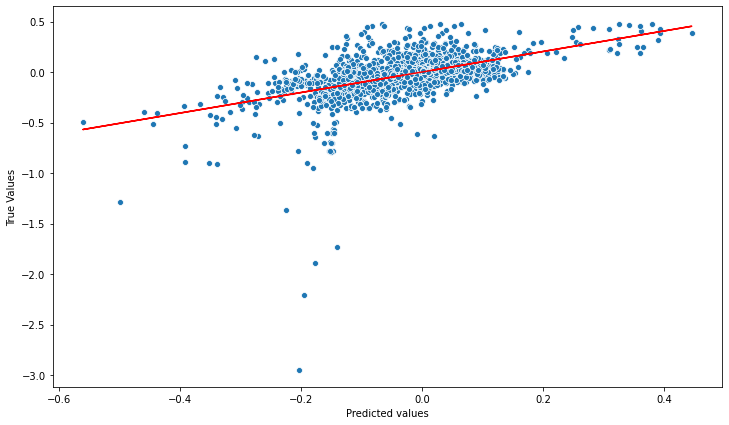

In [267]:
m, b = np.polyfit(pred_4, y_train, 1)
plt.plot(pred_4, m*pred_4 + b,color='red')
sns.scatterplot(pred_4,y_train)
plt.xlabel('Predicted values')
plt.ylabel('True Values');

In [268]:
sns.distplot(error_4)
plt.xlabel('Error');

In [283]:
pred_4_invlog = post_pred_4['observed'].mean(axis=0)
print(f'RMSE is {np.sqrt(mean_squared_error(y_train,pred_4_invlog))}')

RMSE is 0.14049557427079173


## Model Comparison

Let's first compare categorical features --

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

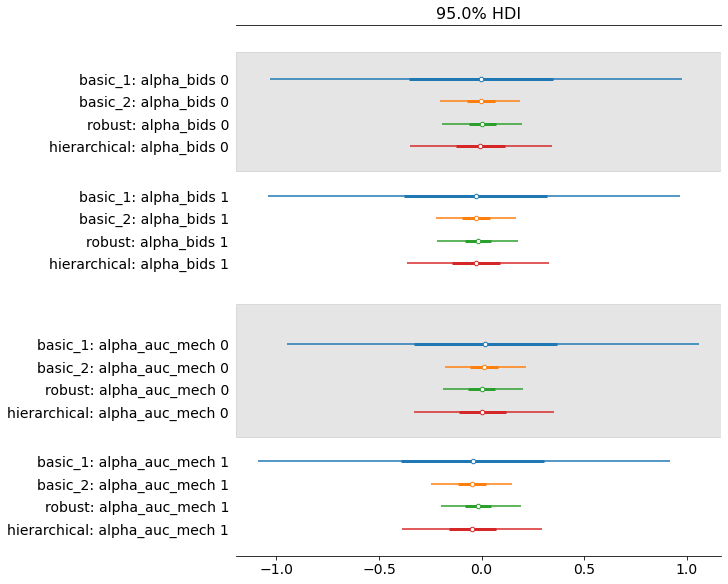

In [103]:
az.plot_forest(data=[trace_1, trace_2,trace_3,trace_4], model_names=['basic_1', 'basic_2','robust','hierarchical'],
    var_names=['alpha_bids','alpha_auc_mech'],combined=True,figsize=(10,8),hdi_prob=0.95)

In [107]:
# az.plot_forest(data=[trace_1, trace_2,trace_3,trace_4], model_names=['basic_1', 'basic_2','robust','hierarchical'],
#     var_names=['alpha_c'],combined=True,figsize=(10,12),hdi_prob=0.95)

Comparing non-categorical features - 

/Users/shaswatrajput/dl/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

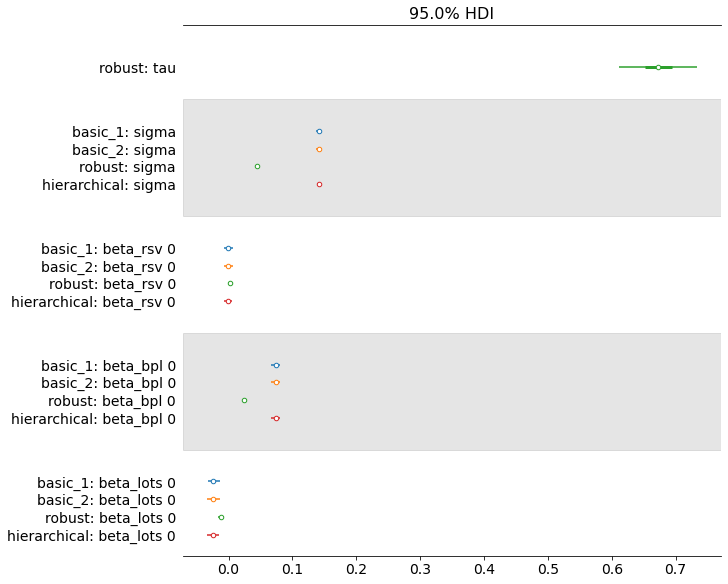

In [301]:
az.plot_forest(data=[trace_1, trace_2,trace_3,trace_4], model_names=['basic_1', 'basic_2','robust','hierarchical'],
    var_names=['tau', 'sigma', 'beta_rsv', 'beta_bpl', 'beta_lots'],combined=True,figsize=(10,8),hdi_prob=0.95)

We can see from the above plots that model estimates are mostly are in-line with each other. 

## Model Comparison 

In [308]:
comp = pm.compare({'basic_1': trace_1, 'basic_2': trace_2,'hierarchical':trace_4,'robust':trace_3})

In [307]:
comp

rank      loo    p_loo    d_loo weight       se      dse warning  \
robust          0  2810.37  52.5322        0    NaN  250.851        0   False   
basic_1         1   1543.4  69.3566  1266.97      0  73.2747  240.905    True   
basic_2         2  1543.04  69.0581  1267.32      0  249.613  241.142    True   
hierarchical    3  1542.32  73.0534  1268.05      0  249.837  242.257    True   

             loo_scale  
robust             log  
basic_1            log  
basic_2            log  
hierarchical       log

As we can see that robust model performed the best out of all the models. 

## Feature Analysis

#### Analysis 1: Forward Auction vs Sealed Bid Auction

We already know from the graph that we plotted in data analysis part is that Forward auction perform better then SealedBid auction based on the point estimates. Let's now see if our belief is right about the data - 

<AxesSubplot:xlabel='Difference'>

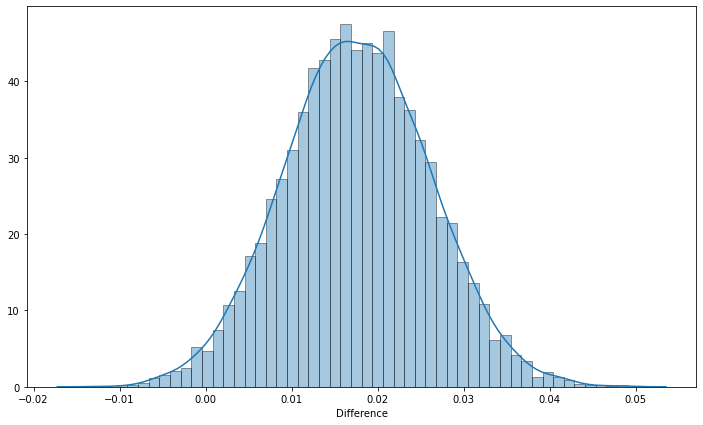

In [119]:
auction_mech_df = pd.DataFrame(trace_3['alpha_auc_mech'],columns=['Forward','SealedBid'])
auction_mech_df['Difference'] = label_itfm(auction_mech_df['Forward']) - label_itfm(auction_mech_df['SealedBid'])
sns.distplot(auction_mech_df['Difference'])

In [121]:
print(f'Mean Difference in RoR: {auction_mech_df["Difference"].mean()}')

Mean Difference in RoR: 0.01761308845610088


From the above plot we can conclude that Forward Auctions perform better than SealedBid auctions.

#### Analysis 2: Posterior Predictive Check 

In [140]:
robust_pred = pm.sample_posterior_predictive(trace_3,model=model_3,samples=500)['observed']
ax = sns.distplot(robust_pred.ravel(),hist_kws={'range':[-2,2]},kde=False,norm_hist=True)
ax.set_xlim(-2,2)
sns.distplot(y_test,hist_kws={'range':[-2,2],'histtype':'step','color':'r'},kde=False,norm_hist=True)

/Users/shaswatrajput/dl/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


<AxesSubplot:>

From the above graph we can say that distribution are kinda similar. Also we can see that distribition of data is more centred around the data's mean than that of model's prediction data mean. 

#### Analysis 3: Imapct of Bidders Per Lot and Number of Lots on ROR

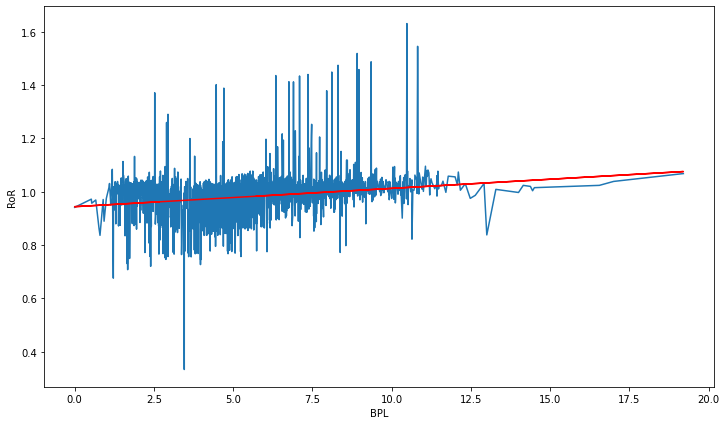

In [234]:
bpl_m = model_df['BPL'].mean()
bpl_s = model_df['BPL'].std()
bpl_tru = BPL*bpl_s+bpl_m
m, b = np.polyfit(bpl_tru, label_itfm(robust_pred.mean(axis=0)), 1)
(sns.lineplot(bpl_tru,label_itfm(robust_pred.mean(axis=0)),ci=None))
plt.plot(bpl_tru, m*bpl_tru+b,color='red')
plt.xlabel('BPL')
plt.ylabel('RoR');

We can see from the above graph that BPL has positive effect on RoR. Intitutively we expected that if more bidders are per lot than RoR is expected to increase which above graph verfied.

In [239]:
lot_m = model_df['lots'].mean()
lot_s = model_df['lots'].std()
lot_tru = lots*lot_s+lot_m
(sns.lineplot(lot_tru,label_itfm(robust_pred.mean(axis=0)),ci=None))
plt.xlabel('Lots')
plt.ylabel('RoR');

We can see that number of lots given has slight negative effect on RoR when there are more lots.

## Conclusions - 

1. On an average Forward Auction are expected to outperform Sealed Bid auction.
2. More bidders per lot have a positive effect on RoR.
3. Number of lots offered have a slighly negative effect on RoR

In [28]:
pm.model_graph.model_to_graphviz(model = model_1)

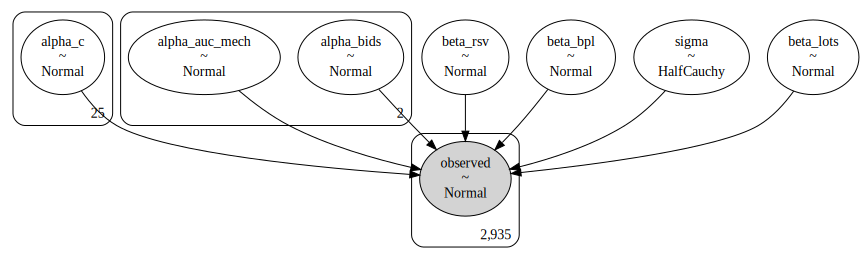

In [30]:
pm.model_graph.model_to_graphviz(model = model_2)

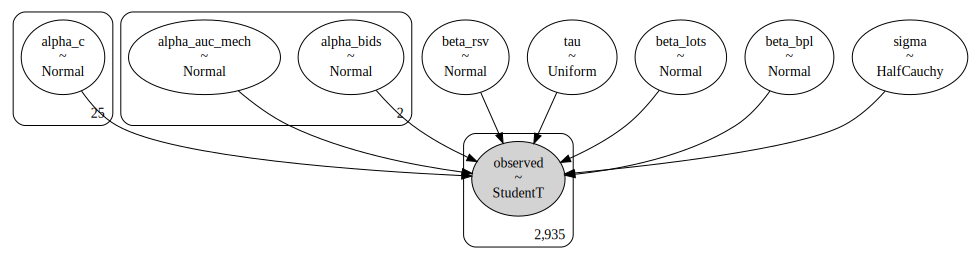

In [32]:
pm.model_graph.model_to_graphviz(model = model_3)

In [44]:
pm.model_graph.model_to_graphviz(model = model_4)

In [1]:
# ax = az.plot_forest(trace_1,r_hat=1,combined=True,ess=1,hdi_prob=0.95)
# fig = plt.gcf() # to get the current figure...
# fig.savefig("disaster.png") # and save it directly